In [1]:
# Yi Qiang's branch 1

import numpy as np
from osgeo import gdal
from pydevd import settrace

# load necessary packages for plotting
from matplotlib import pyplot
import rasterio
from rasterio.plot import show

# import the focal_stat function
# import focal_stats 

In [2]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import numpy as np
from osgeo import gdal
from pydevd import settrace

"""
GDALDataType:
GDT_Unknown = 0, GDT_Byte = 1, GDT_UInt16 = 2, GDT_Int16 = 3, 
GDT_UInt32 = 4, GDT_Int32 = 5, GDT_Float32 = 6, GDT_Float64 = 7, 
GDT_CInt16 = 8, GDT_CInt32 = 9, GDT_CFloat32 = 10, GDT_CFloat64 = 11, 
GDT_TypeCount = 12
"""


dataTypes = {gdal.GDT_Byte : int, #@UndefinedVariable
            gdal.GDT_UInt16 : int, #@UndefinedVariable
            gdal.GDT_Int16 : int, #@UndefinedVariable
            gdal.GDT_UInt32 : int, #@UndefinedVariable
            gdal.GDT_Int32 : int, #@UndefinedVariable
            gdal.GDT_Float32 : float, #@UndefinedVariable
            gdal.GDT_Float64 : float, #@UndefinedVariable
            gdal.GDT_CInt16 : np.complex,
            gdal.GDT_CInt32 : np.complex,
            gdal.GDT_CFloat32 : np.complex,
            gdal.GDT_CFloat64 : np.complex
            }

dataTypesFromInt = {0 : gdal.GDT_Byte,
                    1 : gdal.GDT_UInt16,
                    2 : gdal.GDT_Int16,
                    3 : gdal.GDT_UInt32,
                    4 : gdal.GDT_Int32,
                    5 : gdal.GDT_Float32,
                    6 : gdal.GDT_Float64,
                    7 : gdal.GDT_CInt16,
                    8 : gdal.GDT_CInt32,
                    9 : gdal.GDT_CFloat32,
                    10 : gdal.GDT_CFloat64
                    }

class rasterInfo(object):
    def __init__(self, gd=None, bandNr=1):
        if gd:
            band = gd.GetRasterBand(bandNr)

            self.maxValue = band.GetMaximum()
            self.minValue = band.GetMinimum()


            if self.maxValue is None or self.minValue is None:
                (self.minValue, self.maxValue) = band.ComputeRasterMinMax(1)

            self.meanValue = (float(self.maxValue)+self.minValue)/2

            self.noDataValue = band.GetNoDataValue()
            if self.noDataValue is None: self.noDataValue = self.minValue-1

            self.dataType = dataTypes[band.DataType]
            self.gdalDataType = band.DataType

            self.projection = gd.GetProjection()
            self.geoTransform = gd.GetGeoTransform()

def rasterSTD(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(np.isnan(u))
    (mh, mw) = mask.shape
    #print(noDataArray)
    dx = mw//2
    dy = mh//2

    for x in range(dx):
        u = np.insert(u, 0, np.nan, axis=1)
        u = np.insert(u, u.shape[1], np.nan, axis=1)
    for y in range(dy):
        u = np.insert(u, 0, np.nan, axis=0)
        u = np.insert(u, u.shape[0], np.nan, axis=0)

    (uh, uw) = u.shape

    out = np.zeros(u.shape, dtype=float)
    #print(rInfo.dataType)
    for w in range(uw-dx-1):
        for h in range(uh-dy-1):
            s = u[h:h+mh,w:w+mw]#*mask
            s = s[s>=0]
            if len(s) == 0: continue #if all values are noDataValue then continue with next cell
            a = np.asarray(s)
            m = np.std(a) 
            out[h+dy,w+dx] = m
            
    if len(noDataArray[0]) != 0:
        out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = np.nan
    return out[dy:-dy,dx:-dx]



def rasterSum(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(np.isnan(u))
    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    for x in range(dx):
        u = np.insert(u, 0, np.nan, axis=1)
        u = np.insert(u, u.shape[1], np.nan, axis=1)
    for y in range(dy):
        u = np.insert(u, 0, np.nan, axis=0)
        u = np.insert(u, u.shape[0], np.nan, axis=0)
    (uh, uw) = u.shape
    out = np.zeros(u.shape, dtype=float)

    for w in range(uw-dx):
        for h in range(uh-dy):
            s = u[h:h+mh,w:w+mw] #*mask
            s = s[s>=0]
            if len(s) == 0: 
                continue #if all values are noDataValue then continue with next cell
            else:
                m = np.sum(s)
                out[h+dy,w+dx] = m
    if len(noDataArray[0]) != 0:
        out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = np.nan
    return out[dy:-dy,dx:-dx]



def rasterMax(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(np.isnan(u))
    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    for x in range(dx):
        u = np.insert(u, 0, np.nan, axis=1)
        u = np.insert(u, u.shape[1], np.nan, axis=1)
    for y in range(dy):
        u = np.insert(u, 0, np.nan, axis=0)
        u = np.insert(u, u.shape[0], np.nan, axis=0)
    (uh, uw) = u.shape
    out = np.zeros(u.shape, dtype=float)

    for w in range(uw-dx):
        for h in range(uh-dy):
            s = u[h:h+mh,w:w+mw] #*mask
            s = s[s>=0]
            if len(s) == 0: 
                continue #if all values are noDataValue then continue with next cell
            else:
                m = np.max(s)
                out[h+dy,w+dx] = m
    if len(noDataArray[0]) != 0:
        out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = np.nan
    return out[dy:-dy,dx:-dx]


def rasterMin(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(np.isnan(u))
    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    for x in range(dx):
        u = np.insert(u, 0, np.nan, axis=1)
        u = np.insert(u, u.shape[1], np.nan, axis=1)
    for y in range(dy):
        u = np.insert(u, 0, np.nan, axis=0)
        u = np.insert(u, u.shape[0], np.nan, axis=0)
    (uh, uw) = u.shape
    out = np.zeros(u.shape, dtype=float)

    for w in range(uw-dx):
        for h in range(uh-dy):
            s = u[h:h+mh,w:w+mw] #*mask
            s = s[s>=0]
            if len(s) == 0: 
                continue #if all values are noDataValue then continue with next cell
            else:
                m = np.min(s)
                out[h+dy,w+dx] = m
    if len(noDataArray[0]) != 0:
        out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = np.nan
    return out[dy:-dy,dx:-dx]


def rasterRange(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(np.isnan(u))
    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    for x in range(dx):
        u = np.insert(u, 0, np.nan, axis=1)
        u = np.insert(u, u.shape[1], np.nan, axis=1)
    for y in range(dy):
        u = np.insert(u, 0, np.nan, axis=0)
        u = np.insert(u, u.shape[0], np.nan, axis=0)
    (uh, uw) = u.shape
    out = np.zeros(u.shape, dtype=float)

    for w in range(uw-dx):
        for h in range(uh-dy):
            s = u[h:h+mh,w:w+mw] #*mask
            s = s[s>=0]
            if len(s) == 0: 
                continue #if all values are noDataValue then continue with next cell
            else:
                m = np.max(s) - np.min(s)
                out[h+dy,w+dx] = m
    if len(noDataArray[0]) != 0:
        out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = np.nan
    return out[dy:-dy,dx:-dx]



def rasterMedian(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(np.isnan(u))

    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    #wm = dx*2
    #hm = dy*2

    for x in range(dx):
        u = np.insert(u, 0, np.nan, axis=1)
        u = np.insert(u, u.shape[1], np.nan, axis=1)
    for y in range(dy):
        u = np.insert(u, 0, np.nan, axis=0)
        u = np.insert(u, u.shape[0], np.nan, axis=0)

    (uh, uw) = u.shape
    #print u, hm, wm

    out = np.zeros(u.shape, dtype=float)

    for w in range(uw-dx-1):
        for h in range(uh-dy-1):
            s = u[h:h+mh,w:w+mw]#*mask
            s = s[s>=0]
            if len(s) == 0: continue #if all values are noDataValue then continue with next cell

            p = list(s)
            p.sort()
            l = len(p)
            l2 = l//2

            if l%2:
                m = p[l2]
            else:
                m = float((p[l2])+p[l2-1])/2
            out[h+dy,w+dx] = m

    if len(noDataArray[0]) != 0:
        out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = np.nan

    return out[dy:-dy,dx:-dx]



def rasterAverage(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(np.isnan(u))
    
    count = simpleMaskCount(raster.shape, mask.shape, noDataArray)

    out = rasterSum(raster, mask, rInfo)/count

    if len(noDataArray[0]) != 0:
        out[noDataArray[0], noDataArray[1]] = np.nan
    return out


def simpleMaskCount(rasterShape, maskShape, noDataArray):
    (rY, rX) = rasterShape
    #rY = rasterShape[0]
    (mY, mX) = maskShape
    #mY = maskShape[0]

    out = np.zeros(rY*rX, dtype=int).reshape(rY,rX)
    count = mY*mX

    dx = mX//2
    dy = mY//2
    #wm = mX-1
    #hm = mY-1
    #print (dx, dy, wm, hm)
    
    out[dy:-dy,dx:-dx] = count


    for x in range(dx):
        out[dy:-dy,x] = mY*(dx+1+x)
        out[dy:-dy,-x-1] = mY*(dx+1+x)


    for y in range(dy):
        out[y,dx:-dx] = (dy+1+y)*mX
        out[-y-1,dx:-dx] = (dy+1+y)*mX


    for x in range(dx):
        for y in range(dy):
            val = (dy+1+y)*(dx+1+x)
            out[y, x] = val
            out[-(y+1),-(x+1)] = val
            out[y, -(x+1)] = val
            out[-(y+1),x] = val

    tmp = np.zeros((rY+dy*2)*(rX+dx*2)).reshape(rY+dy*2,rX+dx*2)
    tmp[dy:-dy,dx:-dx] = out

    for i in range(len(noDataArray[0])):
        tmp[noDataArray[0][i]:noDataArray[0][i]+(2*dy)+1,noDataArray[1][i]:noDataArray[1][i]+(2*dx)+1] -= 1

    return tmp[dy:-dy,dx:-dx]


def mask_count(self):
    u = self.big_r #np.array(self.big_r, copy=True)
    dx = self.size_x
    dy = self.size_y
    wm = dx*2
    hm = dy*2
    out = np.zeros(u.shape, dtype=int)

    c = list(self.mask.flatten()).count(0)
    out[hm:-hm,wm:-wm] = self.mask.size-c

    for x in range(dx):
        c = list(self.mask[:, dx-x:].flatten()).count(0)
        out[hm:-hm,x+dx] = self.mask[:, dx-x:].size-c
        c = list(self.mask[:, :dx+1+x].flatten()).count(0)
        out[hm:-hm,-(x+1+dx)] = self.mask[:, :dx+1+x].size-c
    for y in range(dy):
        c = list(self.mask[dy-y:, :].flatten()).count(0)
        out[y+dy,wm:-wm] = self.mask[dy-y:, :].size-c
        c = list(self.mask[:dy+1+y, :].flatten()).count(0)
        out[-(y+1+dy),wm:-wm] = self.mask[:dy+1+y, :].size-c
        #rogi
    for x in range(dx):
        for y in range(dy):
            c = list(self.mask[dy:, dx-x:].flatten()).count(0)
            out[y+dy, x+dx] = self.mask[dy:, dx-x:].size-c
            
            c = list(self.mask[:dy+y+1, :dx+x+1].flatten()).count(0)
            out[-(y+1+dy),-(x+1+dx)] = self.mask[:dy+y+1, :dx+x+1].size-c
            
            c = list(self.mask[:dy+y+1, dx-x:].flatten()).count(0)
            out[-(y+1+dy), x+dx] = self.mask[:dy+y+1, dx-x:].size-c

            c = list(self.mask[dy:, :dx+x+1].flatten()).count(0)
            out[y+dy, -(x+1+dx)] = self.mask[dy:, :dx+x+1].size-c

    rast_nan = np.where(np.nan(u[dy:-dy,dx:-dx]))
    rast_nan = (rast_nan[0]+dy,rast_nan[1]+dx)
    rev_mask = np.fliplr(self.mask[::-1])

    for i in range(rast_nan[0].size):
        ry = rast_nan[0][i]
        rx = rast_nan[1][i]
        out[ry-dy:ry+dy+1,rx-dx:rx+dx+1] -= rev_mask

    return out[dy:-dy,dx:-dx]


def SaveToFile(FileName, raster, rInfo):
    
    driver = gdal.GetDriverByName("GTiff")

    dst_ds = driver.Create(FileName, raster.shape[1], raster.shape[0], 1, rInfo.gdalDataType, ['COMPRESS=DEFLATE'])
    dst_ds.SetGeoTransform(rInfo.geoTransform)
    dst_ds.SetProjection(rInfo.projection)
    dst_ds.FlushCache()
    if rInfo.noDataValue:
        dst_ds.GetRasterBand(1).SetNoDataValue(rInfo.noDataValue )
    dst_ds.GetRasterBand(1).WriteArray(raster)
    # Once we're done, close properly the dataset
    del dst_ds
    

    
# def array2raster(raster,outputfilepath,array):
#     raster = gdal.Open(raster)
#     geotransform = raster.GetGeoTransform()
#     originX = geotransform[0]
#     originY = geotransform[3]
#     pixelWidth = geotransform[1]
#     pixelHeight = geotransform[5]
#     cols = raster.RasterXSize
#     rows = raster.RasterYSize

#     driver = gdal.GetDriverByName('GTiff')
#     outRaster = driver.Create(FileName, cols, rows, 1, gdal.GDT_Float32)
#     outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
#     outband = outRaster.GetRasterBand(1)
#     outband.WriteArray(array)
#     outRasterSRS = osr.SpatialReference()
#     outRasterSRS.ImportFromWkt(raster.GetProjectionRef())
#     outRaster.SetProjection(outRasterSRS.ExportToWkt())
#     outband.FlushCache()

def focal_stats(input_raster_path, dimension, focal_function,output_raster_path = None, show_na = None):
    try:
        mask = np.ones(dimension)
    except:
        print("please input a valid dimension")
        return
    gd = gdal.Open(input_raster_path)
    raster = gd.ReadAsArray().astype(float) # get array with raster to float type
    in_band = gd.GetRasterBand(1)
    nodata = in_band.GetNoDataValue()
    rInfo = rasterInfo(gd)
    switcher = {
        "mean": rasterAverage,
        "max": rasterMax,
        "min": rasterMin,
        "std": rasterSTD,
        "median": rasterMedian,
        "sum": rasterSum,
        "range": rasterRange
    }

    print("The dataset has "+str(np.isclose(raster[:,:,None],nodata).any(2).sum())+" pixels with No Data Value (" +
         str(rInfo.noDataValue)+")")
    raster[np.isclose(raster[:,:,None],nodata).any(2)] = np.nan # convert all null value to np.nan
    np.warnings.filterwarnings("ignore", message="invalid value encountered in greater_equal")
    func = switcher.get(focal_function, lambda: "Invalid function name")
    rasteroutput = func(raster, mask, rInfo)
    rasteroutput[np.isnan(rasteroutput)] = rInfo.noDataValue
    if output_raster_path:
        print("The raster file has been exported to "+output_raster_path)
        SaveToFile(output_raster_path, rasteroutput, rInfo) # the output_type is from datatype int
    if not show_na:    
        rasteroutput[np.isclose(rasteroutput[:,:,None],nodata).any(2)] = np.nan
    return(rasteroutput)




## Loading original raster

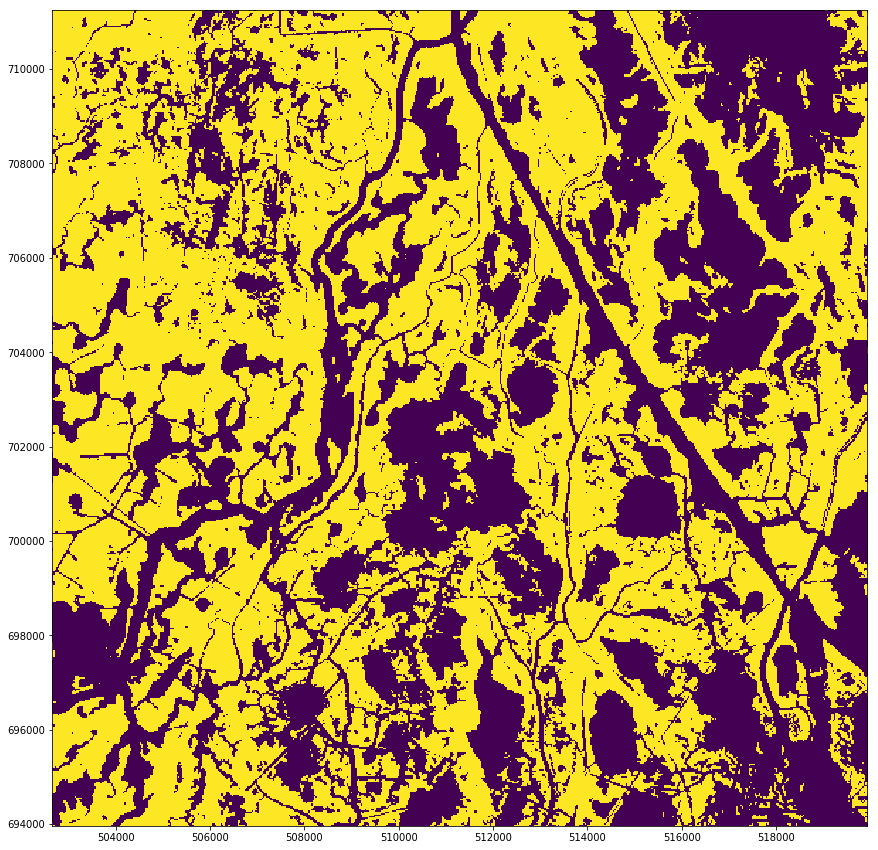

In [3]:
fn = "land_2010.tif"
src = rasterio.open(fn)
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(src)

## Apply focal operator

In [4]:
# focal_stats have four parameters
# 1 - "input file path and name", 
# 2 - dimention in (n,n) format,
# 3 - function in quotation marks, like std/mean/max/min/median/range/sum
# 4 - optional output raster path and name, must be in the format of tiff, or the visualization will have issues
# 5 - show_na is deciding whether to involve na in the plot (not suggested)

raster_std = focal_stats(fn,(3,3),"std",output_raster_path = "std.tif",show_na = True)

The dataset has 0 pixels with No Data Value (255.0)
The raster file has been exported to std.tif


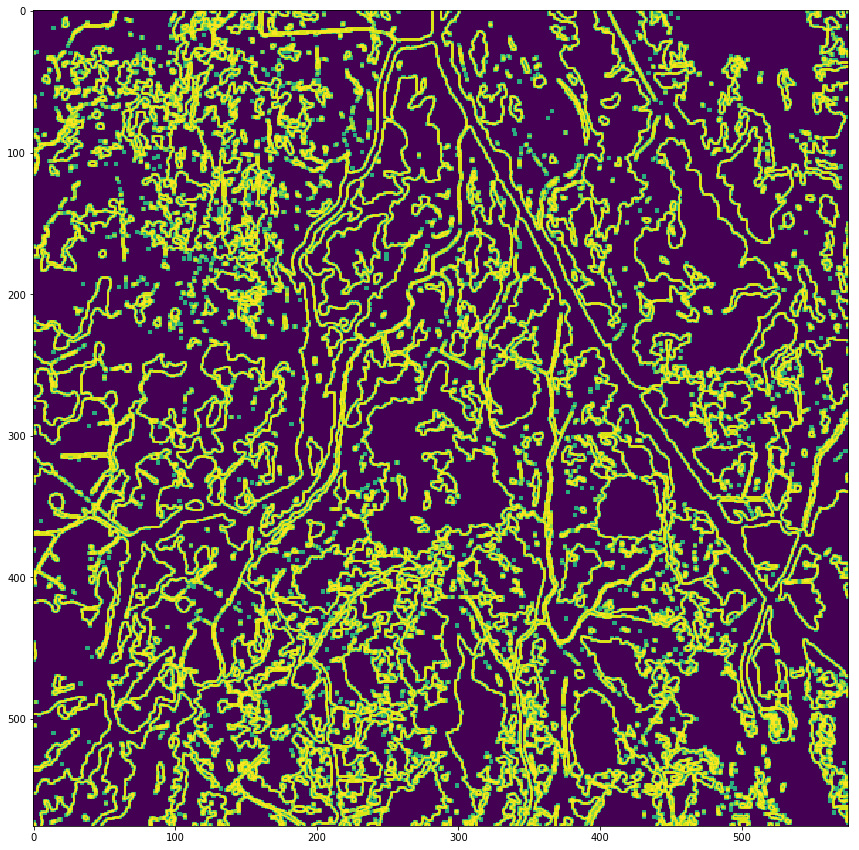

In [6]:
%matplotlib inline
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_std)

In [7]:
# test sum
raster_sum = focal_stats(fn,(3,3),"sum",output_raster_path = "sum.tif")

The dataset has 0 pixels with No Data Value (255.0)
The raster file has been exported to sum.tif


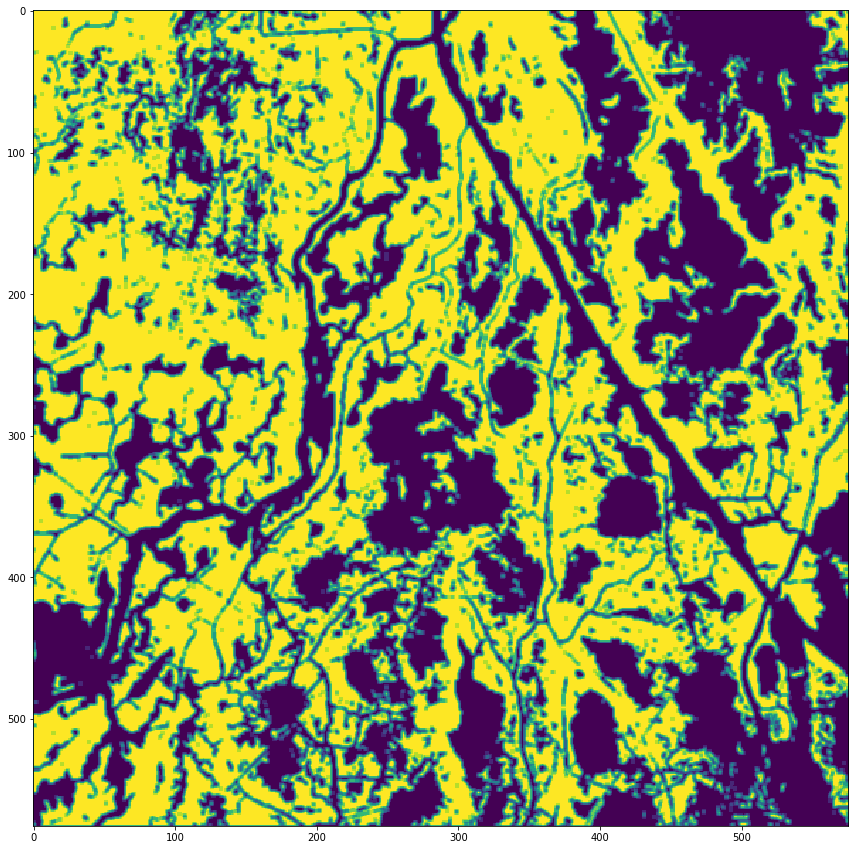

In [8]:
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_sum)

In [9]:
# test mean
raster_mean = focal_stats(fn,(3,3),"mean",output_raster_path = "mean.tif")

The dataset has 0 pixels with No Data Value (255.0)
The raster file has been exported to mean.tif


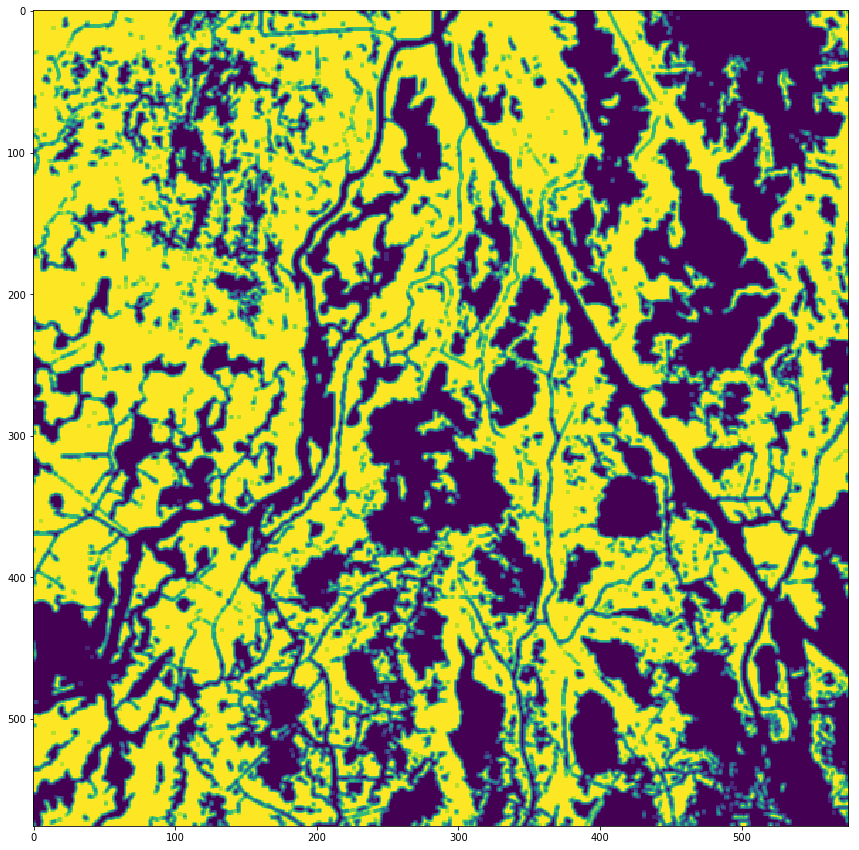

In [10]:
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_mean)

In [11]:
# test max
raster_max = focal_stats(fn,(3,3),"max",output_raster_path = "max.tif")

The dataset has 0 pixels with No Data Value (255.0)
The raster file has been exported to max.tif


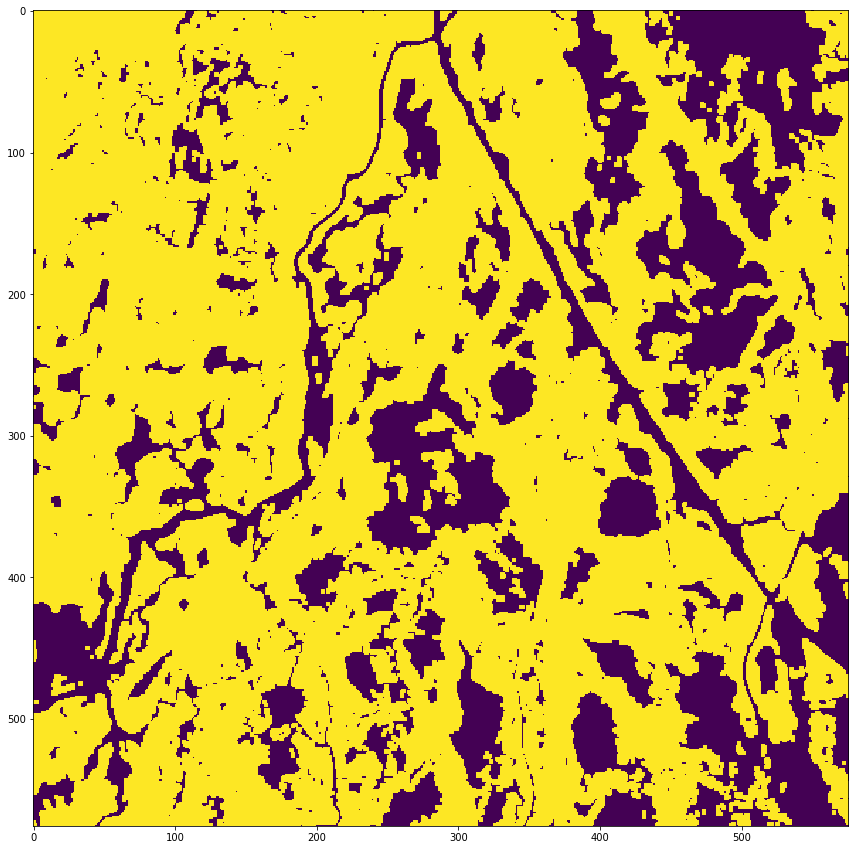

In [12]:
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_max)

In [13]:
# test min
raster_min = focal_stats(fn,(3,3),"min",output_raster_path = "min.tif")

The dataset has 0 pixels with No Data Value (255.0)
The raster file has been exported to min.tif


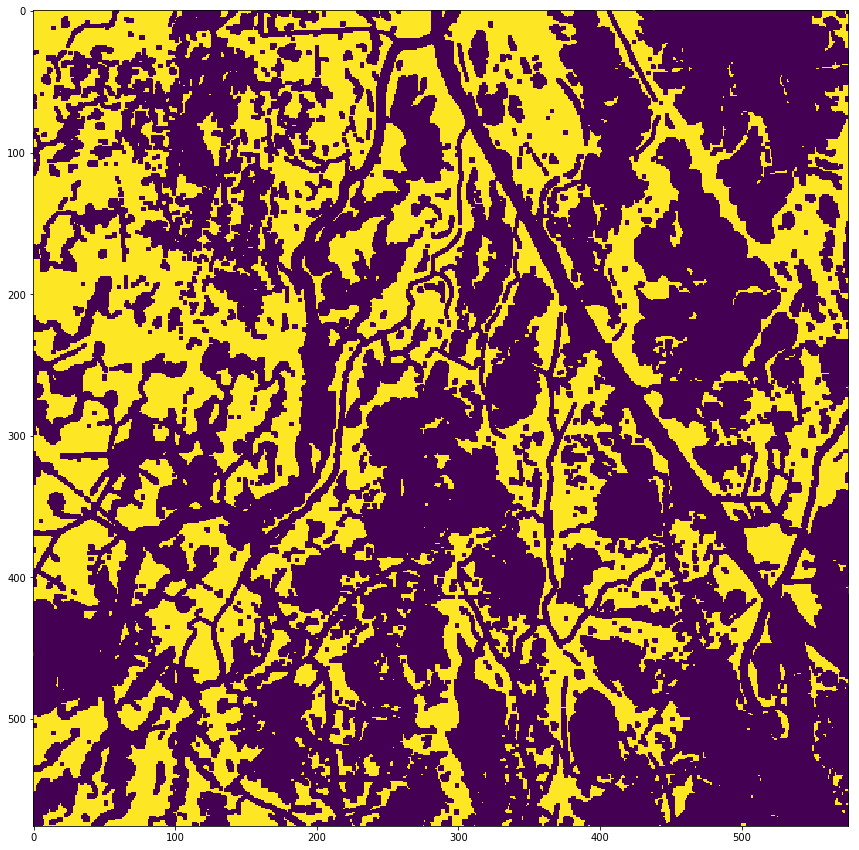

In [14]:
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_min)

In [15]:
# test median
raster_median = focal_stats(fn,(3,3),"median",output_raster_path = "median.tif")

The dataset has 0 pixels with No Data Value (255.0)
The raster file has been exported to median.tif


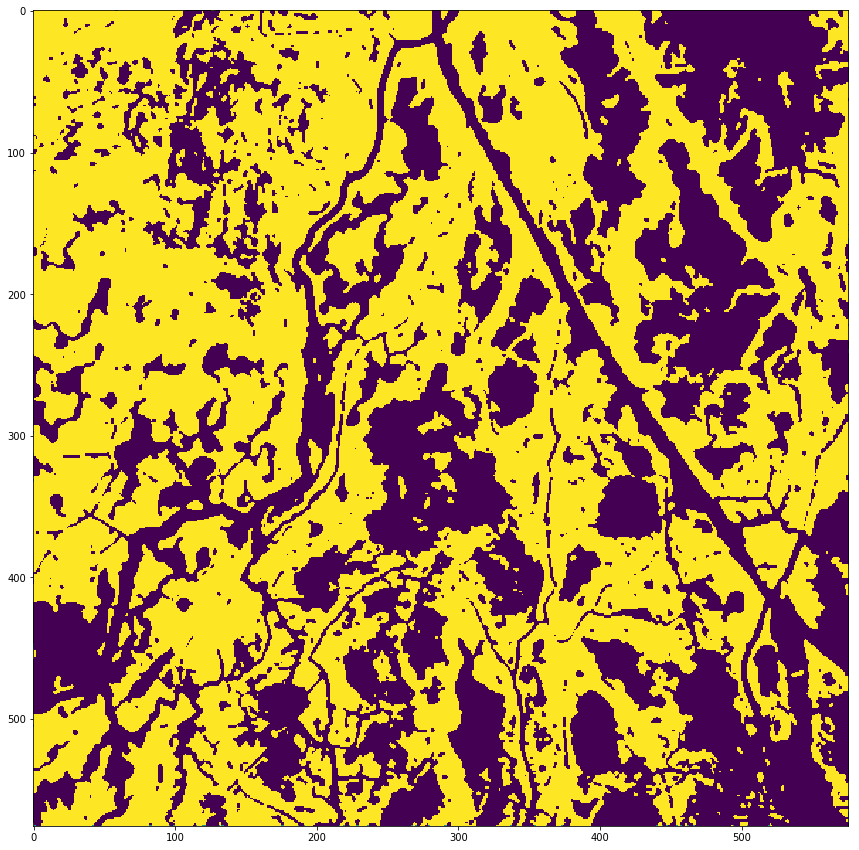

In [16]:
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_median)

In [17]:
# test range
raster_range = focal_stats(fn,(3,3),"range",output_raster_path = "range.tif")

The dataset has 0 pixels with No Data Value (255.0)
The raster file has been exported to range.tif


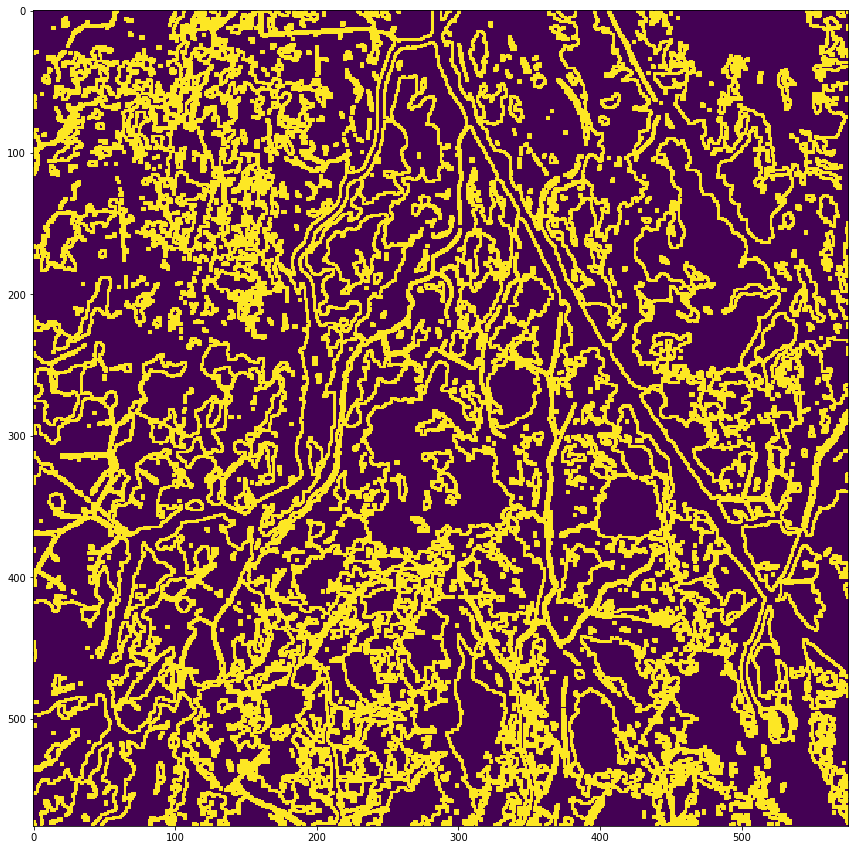

In [18]:
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_range)